In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from PIL import Image
%matplotlib inline

In [2]:
# Load movies
movies = pd.read_csv("./small_data/ml-latest-small//movies.csv")
#movies = movies.replace({np.nan: None}) # replace NaN with None
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Load movies
links = pd.read_csv("./data/links.csv")
links = links.replace({np.nan: None}) # replace NaN with None
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [4]:
# Load movies
ratings = pd.read_csv("./data/ratings.csv")
#ratings = ratings.replace({np.nan: None}) # replace NaN with None
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Load movies
tags = pd.read_csv("./data/tags.csv")
tags = tags.replace({np.nan: None}) # replace NaN with None
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
movies.count()

movieId    9742
title      9742
genres     9742
dtype: int64

In [7]:
links.count()

movieId    9742
imdbId     9742
tmdbId     9734
dtype: int64

In [8]:
ratings.count()

userId       100836
movieId      100836
rating       100836
timestamp    100836
dtype: int64

In [9]:
tags.count()

userId       3683
movieId      3683
tag          3683
timestamp    3683
dtype: int64

In [10]:
print("If there is missing data in each table?")
print('movie: {}'.format(movies.count() == movies.dropna().count()))
print('ratings: {}'.format(ratings.count() == ratings.dropna().count()))
print('links: {}'.format(links.count() == links.dropna().count()))
print('tags: {}'.format(tags.count() == tags.dropna().count()))

If there is missing data in each table?
movie: movieId    True
title      True
genres     True
dtype: bool
ratings: userId       True
movieId      True
rating       True
timestamp    True
dtype: bool
links: movieId    False
imdbId     False
tmdbId      True
dtype: bool
tags: userId       True
movieId      True
tag          True
timestamp    True
dtype: bool


In [11]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
5,6,Heat,Action|Crime|Thriller,1995
6,7,Sabrina,Comedy|Romance,1995
7,8,Tom and Huck,Adventure|Children,1995
8,9,Sudden Death,Action,1995
9,10,GoldenEye,Action|Adventure|Thriller,1995


In [33]:
# Genres
all_genres = [s.split("| ") for s in movies[movies.genres.notnull()].genres]
genres = [item for l in all_genres for item in l ]
unique_genres = set(genres)
print (f"total of {len(unique_genres)} unique genres from {len(genres)} occurances.")
pd.Series(genres).value_counts().plot(kind='bar', figsize=(10, 3))
plt.title("# of movies per genre")
plt.ylabel("# of movies")
plt.xlabel("genre")
plt.show()

AttributeError: 'list' object has no attribute 'split'

Total of 106 uinque years from 1902 to 2018


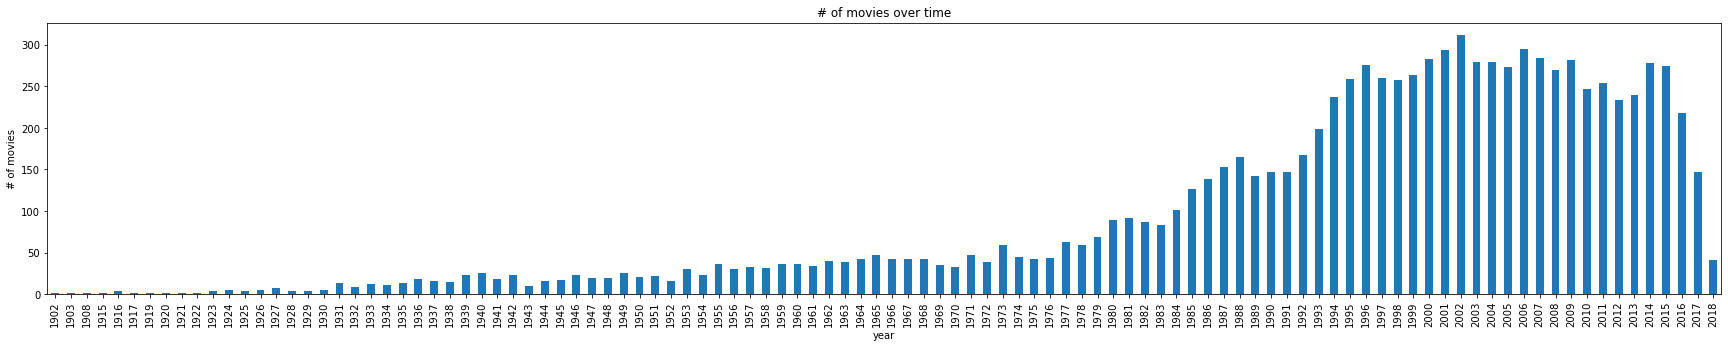

In [12]:
# Years
years = movies[movies.year.notnull()].year # get rows where year is not None
print (f"Total of {len(set(years))} uinque years from {min(years)} to {max(years)}")
pd.Series(years).value_counts().sort_index().plot(kind='bar', figsize=(30, 5))
plt.title("# of movies over time")
plt.ylabel("# of movies")
plt.xlabel("year")
plt.show()

In [13]:
#Every genre is separated by a | so we simply have to call the split function on |
movies['genres'] = movies.genres.str.split('|')
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
5,6,Heat,"[Action, Crime, Thriller]",1995
6,7,Sabrina,"[Comedy, Romance]",1995
7,8,Tom and Huck,"[Adventure, Children]",1995
8,9,Sudden Death,[Action],1995
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995


In [14]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
moviesWithGenres = movies.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies.iterrows():
    for genre in row['genres']:
        moviesWithGenres.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres = moviesWithGenres.fillna(0)
moviesWithGenres.head(10)

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,Heat,"[Action, Crime, Thriller]",1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,Sabrina,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,Tom and Huck,"[Adventure, Children]",1995,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,Sudden Death,[Action],1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#Drop removes a specified row or column from a dataframe
ratings = ratings.drop('timestamp', 1)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [16]:
#Merge is a function that combines all the rows of the dataset with the specified dataframe.
data = ratings.merge(movies,on='movieId', how='left')
data.head(10)

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,1,3,4.0,Grumpier Old Men,"[Comedy, Romance]",1995
2,1,6,4.0,Heat,"[Action, Crime, Thriller]",1995
3,1,47,5.0,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995
4,1,50,5.0,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995
5,1,70,3.0,From Dusk Till Dawn,"[Action, Comedy, Horror, Thriller]",1996
6,1,101,5.0,Bottle Rocket,"[Adventure, Comedy, Crime, Romance]",1996
7,1,110,4.0,Braveheart,"[Action, Drama, War]",1995
8,1,151,5.0,Rob Roy,"[Action, Drama, Romance, War]",1995
9,1,157,5.0,Canadian Bacon,"[Comedy, War]",1995


# Content-Based Recommendation system

In [27]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [30]:
movie_profile = movies[['movieId', 'title', 'genres']]
movie_profile.rename(columns={'id': 'movieId'}, inplace=True)
genres = [item.strip() for l in all_genres for item in l ]
unique_genres = set(genres)
for genre in unique_genres:
  movie_profile[genre] = 0

/Users/brianm/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


NameError: name 'all_genres' is not defined

In [42]:
userInput = [
            {'title':'Fast & Furious (Fast and the Furious 4, The)', 'rating':4},
            {'title':'Jumanji: Welcome to the Jungle', 'rating':4.5},
            {'title':'Secret Superstar', 'rating':3},
            {'title':"Captain Marvel", 'rating':3.5},
            {'title':'Intern, The', 'rating':5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Fast & Furious (Fast and the Furious 4, The)",4.0
1,Jumanji: Welcome to the Jungle,4.5
2,Secret Superstar,3.0
3,Captain Marvel,3.5
4,"Intern, The",5.0


In [43]:
#Filtering out the movies by title
inputId = movies[movies['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('genres', 1).drop('year', 1)
#Final input dataframe
#If a movie you added in above isn't here, then it might not be in the original 
#dataframe or it might spelled differently, please check capitalisation.
inputMovies

,movieId,title,rating
0,67923,"Fast & Furious (Fast and the Furious 4, The)",4.0
1,179401,Jumanji: Welcome to the Jungle,4.5


In [45]:
#Filtering out the movies from the input
userMovies = moviesWithGenres[moviesWithGenres['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
7006,67923,"Fast & Furious (Fast and the Furious 4, The)","[Action, Crime, Drama, Thriller]",2009,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9636,179401,Jumanji: Welcome to the Jungle,"[Action, Adventure, Children]",2017,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#Resetting the index to avoid future issues
userMovies = userMovies.reset_index(drop=True)
#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
inputMovies['rating']

0    4.0
1    4.5
Name: rating, dtype: float64

In [48]:
#Dot produt to get weights
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
#The user profile
userProfile

Adventure             4.5
Animation             0.0
Children              4.5
Comedy                0.0
Fantasy               0.0
Romance               0.0
Drama                 4.0
Action                8.5
Crime                 4.0
Thriller              4.0
Horror                0.0
Mystery               0.0
Sci-Fi                0.0
War                   0.0
Musical               0.0
Documentary           0.0
IMAX                  0.0
Western               0.0
Film-Noir             0.0
(no genres listed)    0.0
dtype: float64

In [50]:
#Now let's get the genres of every movie in our original dataframe
genreTable = moviesWithGenres.set_index(moviesWithGenres['movieId'])
#And drop the unnecessary information
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
genreTable.shape

(9742, 20)

In [53]:
#Multiply the genres by the weights and then take the weighted average
recommendationTable = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable.head()

movieId
1    0.305085
2    0.305085
3    0.000000
4    0.135593
5    0.000000
dtype: float64

In [54]:
#Sort our recommendations in descending order
recommendationTable = recommendationTable.sort_values(ascending=False)
#Just a peek at the values
recommendationTable.head()

movieId
26504    0.864407
49530    0.847458
459      0.847458
6016     0.847458
81132    0.847458
dtype: float64

In [56]:
#The final recommendation table
movies.loc[movies['movieId'].isin(recommendationTable.head(20).keys())]

,movieId,title,genres,year
400,459,"Getaway, The","[Action, Adventure, Crime, Drama, Romance, Thr...",1994
1747,2344,Runaway Train,"[Action, Adventure, Drama, Thriller]",1985
1814,2414,Young Sherlock Holmes,"[Action, Adventure, Children, Fantasy, Mystery...",1985
1822,2422,"Karate Kid, Part III, The","[Action, Adventure, Children, Drama]",1989
1828,2429,Mighty Joe Young,"[Action, Adventure, Drama, Fantasy, Thriller]",1998
2623,3508,"Outlaw Josey Wales, The","[Action, Adventure, Drama, Thriller, Western]",1976
3085,4142,Left Behind: The Movie,"[Action, Adventure, Drama, Thriller]",2000
4176,6016,City of God (Cidade de Deus),"[Action, Adventure, Crime, Drama, Thriller]",2002
4409,6503,Charlie's Angels: Full Throttle,"[Action, Adventure, Comedy, Crime, Thriller]",2003
4859,7262,Catch That Kid,"[Action, Adventure, Children, Comedy, Crime]",2004


# Collaborative Filtering based Recommendation System